In [209]:
import os
import pickle
from statistics import median

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import qutip as qt
import nmrglue as ng

# import pulsee.simulation as sim

# Determining the resolution of the plots for displaying & savingpetpet
import tomography.operators as op
import tomography.global_constants as glob
import tomography.tomography_helper_functions as helper
from tomography.coeff_groups_class import CoefficientGroups, clean_dm

from tomography.plot_dm import plot_complex_density_matrix

# commented out cuz it causes my computer to not plot anything:
#%matplotlib notebook

DPI_DISPLAY = glob.DPI_DISPLAY
DPI_SAVE = glob.DPI_SAVE

plt.rcParams['figure.dpi'] = DPI_DISPLAY
plt.rcParams['font.family'] = ['Helvetica']

""" This is to save plots as PDF with editable text (so that Adobe illustrator recognizes text) """
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [210]:
FILE_TYPE = "pdf"
FIGURE_FOLDER = f"C:/Users/lemon/OneDrive - Brown University/CNOT project/Publication/images/tomography/{FILE_TYPE}"

# Importing Data
Rearranged folders (from Donny's usual format) so that both P1 and P2 files are in the same folder. This way I don't have to deal with separate "P1" and "P2" folders.

In [211]:
state_name = "0001_CNOT"
Bruker_folders_path = "C:/Users/lemon/OneDrive - Brown University/CNOT project/tomography/data/Bruker_folders/2024_02_14/"

Making sure the folder names are sorted by increasing NUMBER value not string value (the difference matters when numbers are 1 digit vs 2 digits)

In [212]:
folder_nums = os.listdir(f"{Bruker_folders_path}/{state_name}")
folder_nums = [str(s) for s in (sorted([int(x) for x in folder_nums]))] # ordering by increasing number value
folder_nums

['13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33']

In [213]:
def get_folder_path(f_n):
    return f"{Bruker_folders_path}/{state_name}/{f_n}/pdata/1"

# all_components=True to get both the real & imaginary spectra
all_data = [ng.bruker.read_pdata(get_folder_path(fn), all_components=True)[1] for fn in folder_nums]

all_data = np.array(all_data)
all_data.shape

(14, 2, 524288)

In [214]:
all_raw_spectra = []
for real, imag in all_data:
    all_raw_spectra.append(real)
    all_raw_spectra.append(imag)

all_raw_spectra = np.array(all_raw_spectra)
all_raw_spectra.shape

(28, 524288)

Flip the frequency axis

In [215]:
all_spectra_unphased = np.flip(all_raw_spectra, axis=1)

# Calculating the frequency axis for the spectrum
All data in below cell is from Donny's email & Bruker plots

According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

All relevant parameters for this measurement:

In [216]:
# Actually relevant:
SPECTRUM_WIDTH = 242.813  #Spectral Width Hertz
BF1 = 242.9532690e6  #BF1 is the basic transmitter frequency. Effectively it is the reference freq. (Levitt pg. 53)
SFO1 = 242.9516595e6  #SFO1 is the transmitter frequency
SF = BF1  #SF is interpreted by display and plot routines for generating the axis (scale) calibration in Bruker (Bruker data graphs SF as the center). Ideally this SF=BF1, as this is the convention in our paper. 

freqs = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_unphased.shape[1])

J = 22.22  # Hz
L_FREQ = -J / 2
R_FREQ = J / 2

# probably won't need...?
SFO2 = 242.9507187e6
bruker_offset = -1633.70
QA = 0.3998008

B_0 = 14.0921  # Tesla
TEMP = 310  # Kelvin

# Doing a 90 degree global phase shift on our plots
Our receiver phase was set to -y, but our theory appears to set the receiver phase to +x
I also put a negative in front of the imaginary spectra because the relationship between the peak phases between the real & imaginary spectra does not line up with the standard theory (Levitt pg 103).
It appears that we need to multiply -1 to our imaginary spectra to agree with the theory. Seems a bit sketchy but works

In [217]:
complex_spectra = []
for i in range(0, len(all_spectra_unphased), 2):
    real = all_spectra_unphased[i]
    imag = all_spectra_unphased[i + 1]
    complex_spectra.append(real - 1j * imag)  # MULTIPLYING -1 TO IMAGINARY SPECTRA

complex_spectra = np.array(complex_spectra)
complex_spectra_transformed = complex_spectra * np.exp(1j * np.pi / 2)

all_spectra_transformed = []
for spectrum in complex_spectra_transformed:
    all_spectra_transformed.append(spectrum.real)
    all_spectra_transformed.append(spectrum.imag)

all_spectra = np.array(all_spectra_transformed)

In [218]:
SFO1_centered_x_axis = np.linspace(SFO1 + SPECTRUM_WIDTH / 2, SFO1 - SPECTRUM_WIDTH / 2, len(freqs))  #SFO1 is center of spectrum
SF_centered_x_axis = np.linspace(SF + SPECTRUM_WIDTH / 2, SF - SPECTRUM_WIDTH / 2, len(freqs))  #SF is center of spectrum
BF1_centered_x_axis = np.linspace(BF1 + SPECTRUM_WIDTH / 2, BF1 - SPECTRUM_WIDTH / 2, len(freqs))  #BF1 is center of spectrum

#We want to form an x-axis where these are centered at 0
freqs_zero_centered = SFO1_centered_x_axis - median(SFO1_centered_x_axis)
freqs_bruker = freqs_zero_centered - (
            median(SF_centered_x_axis) - median(SFO1_centered_x_axis))  #SF is centered, this is how Bruker graphs data
new_freqs = freqs_zero_centered - (median(BF1_centered_x_axis) - median(
    SFO1_centered_x_axis))  #Data centered with BF1=0, This is how we will do it in the paper

In [219]:
median(freqs_bruker)

-1609.5

In [220]:
median(new_freqs)

-1609.5

In [221]:
freqs

array([-121.4065    , -121.40603687, -121.40557374, ...,  121.40557374,
        121.40603687,  121.4065    ])

In [222]:
SFO1_centered_x_axis = np.linspace(SFO1 + SPECTRUM_WIDTH / 2, SFO1 - SPECTRUM_WIDTH / 2, len(freqs))  #SFO1 is center of spectrum
SF_centered_x_axis = np.linspace(SF + SPECTRUM_WIDTH / 2, SF - SPECTRUM_WIDTH / 2, len(freqs))  #SF is center of spectrum
BF1_centered_x_axis = np.linspace(BF1 + SPECTRUM_WIDTH / 2, BF1 - SPECTRUM_WIDTH / 2, len(freqs))  #BF1 is center of spectrum

#We want to form an x-axis where these are centered at 0
freqs_zero_centered = SFO1_centered_x_axis - SFO1
freqs_bruker = SFO1_centered_x_axis - SF  #SF is centered, this is how Bruker graphs data
new_freqs = freqs_zero_centered + SFO1 - BF1  #Data centered with BF1=0, This is how we will do it in the paper

`freqs_bruker` and `new_freqs` are identical!

Flipping `new_freqs` so it's increasing

In [223]:
new_freqs_old = np.flip(new_freqs)

In [224]:
def hz_to_ppm(x):  #transform
    return (x / BF1) * 1E6


def ppm_to_hz(x):  #inverse transform
    return x * 1E-6 * BF1

In [225]:
def khz_to_ppm(x):
    return hz_to_ppm(x) * 1000


def ppm_to_khz(x):
    return ppm_to_hz(x) / 1000

In [226]:
# spectrum = all_spectra[12] * 1e-8
# 
# fig, ax = plt.subplots(constrained_layout=True)
# 
# ax.plot(new_freqs, spectrum, color='black')
# ax.set_xlabel('Offset Frequency (Hz)')
# ax.set_ylabel('Signal (a.u.)')
# ax.set_title('Spectrum Paper Calibrated')
# secax = ax.secondary_xaxis('top', functions=(hz_to_ppm, ppm_to_hz), color='black')
# secax.set_xlabel('Offset Frequency (PPM)', color='black')
# 
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_color('black')
# ax.xaxis.label.set_color('black')
# 
# secax.tick_params(direction='in', axis='x', colors='black')
# ax.tick_params(direction='in', axis='x', colors='black')
# ax.tick_params(direction='in', axis='y', colors='black')
# 
# ax.fill_between(new_freqs, spectrum, color='#334c80')
# ax.fill_between(new_freqs, spectrum, where=new_freqs > -2578,
#                 color='#759ebc')
# 
# ax.fill_between(new_freqs, spectrum, where=new_freqs > -2200,
#                 color='#9c4629')
# ax.fill_between(new_freqs, spectrum, where=new_freqs > -1649,
#                 color='#6f1d20')
# 
# #plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=+2.4295e8)
# # ax.xaxis.get_offset_text().set_fontsize(16)
# ax.xaxis.set_tick_params()
# ax.yaxis.set_tick_params()
# secax.xaxis.set_tick_params()
# #Force the y-axis ticks to use 1e-9 as a base exponent 
# #ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-8)))
# 
# 
# # plt.xlim(-2900, -1250)
# #plt.ylim(-.1 , 4)
# 
# 
# plt.show()

# Plots for Publication!!
Adding a offset to the center by eye, since the doublet isn't exactly centered at the median of the frequency.

In [227]:
spectrum = all_spectra[11] * 1e-4  # multiplying negative so the spectrum shows positive y values
EYEBALL_OFFSET = -5
new_center_old = median(new_freqs_old) + EYEBALL_OFFSET

J = 22.22  # Hz
L_FREQ = new_center_old - J / 2
R_FREQ = new_center_old + J / 2


Converting Hz into kHz

In [228]:
new_freqs = new_freqs_old / 1000
int_width = J / 1000
new_center = new_center_old / 1000
l_center = L_FREQ / 1000
r_center = R_FREQ / 1000
X_LIMS_WIDTH = 60 / 1000

In [229]:
Q1_L_COLOR_NEW = "#489FC1"
Q1_R_COLOR_NEW = "#0A6078"

In [230]:
spectrum.shape, new_freqs.shape

((524288,), (524288,))

In [231]:
N_INTERP = 1000
xs_interp = np.linspace(new_center - X_LIMS_WIDTH/2 - 10/1000, new_center + X_LIMS_WIDTH/2 + 10/1000, N_INTERP)
ys_interp = np.interp(xs_interp, new_freqs, spectrum)

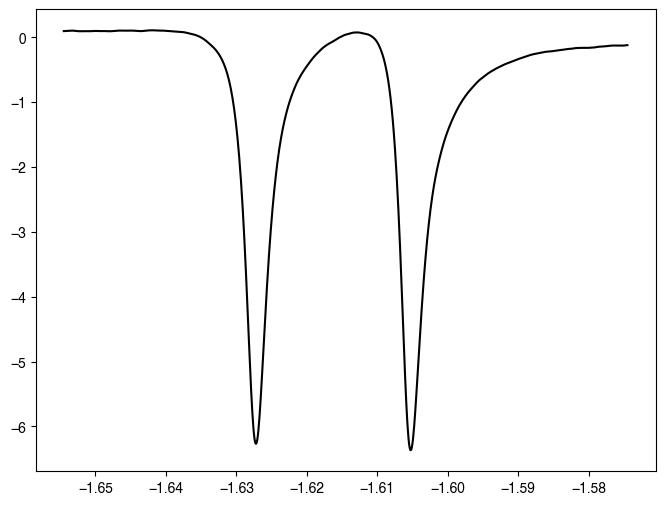

In [232]:
spectrum = all_spectra[11] * -1e-4
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xs_interp, ys_interp, color='black')


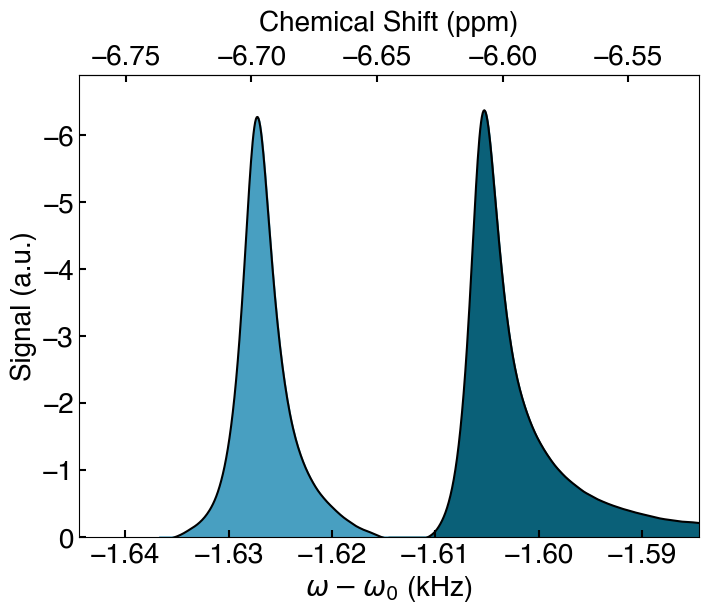

In [233]:
LABEL_SIZE = 20

fig, ax = plt.subplots(figsize=(8, 6))
# ax.set_title("NMR spectrum of Q1: Pulse X1X2, imaginary part", fontsize=16)
ax.set_xlabel("$\omega - \omega_0$ (kHz)", fontsize=LABEL_SIZE)
ax.set_ylabel("Signal (a.u.)", fontsize=LABEL_SIZE)

ax.plot(xs_interp, ys_interp, color='black')
ax.set_xlim(new_center - X_LIMS_WIDTH/2, new_center + X_LIMS_WIDTH/2)
ax.set_ylim(0, -6.9)

# centers verified by eyeballing vertical lines
i_l_lo = np.absolute(xs_interp - (l_center - int_width / 2)).argmin()
i_l_hi = np.absolute(xs_interp - (l_center + int_width / 2)).argmin()
i_r_lo = np.absolute(xs_interp - (r_center - int_width / 2)).argmin()
i_r_hi = np.absolute(xs_interp - (r_center + int_width * 2)).argmin()

ax.fill_between(xs_interp[i_l_lo: i_l_hi], ys_interp[i_l_lo: i_l_hi], color=Q1_L_COLOR_NEW)
ax.fill_between(xs_interp[i_r_lo: i_r_hi], ys_interp[i_r_lo: i_r_hi], color=Q1_R_COLOR_NEW)

# setting the second x-axis at the top
sec_ax = ax.secondary_xaxis('top', functions=(khz_to_ppm, ppm_to_khz))
sec_ax.set_xlabel('Chemical Shift (ppm)', fontsize=LABEL_SIZE, labelpad=10)
# sec_ax.xaxis.set_label_coords(1.02, 0.9)
# sec_ax.xaxis.set_label_coords(1.02, 20)


# making axis tick labels smaller

ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
sec_ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
# sec_ax.set_xticks(sec_ax.get_xticks()[::2])
# ax.tick_params(axis='both', which='minor', labelsize=1)

# ax.grid() # Get rid of grid, since publications don't like them?
# ax.axvline(L_FREQ, color='r', alpha=0.5)
# ax.axvline(R_FREQ, color='r', alpha=0.5)
# ax.axvline(new_center, color='orange', alpha=0.5)

# ax.yaxis.set_major_locator(MaxNLocator(prune='upper'))

plt.savefig(f"{FIGURE_FOLDER}/02_14_x1x2_imag_spectrum.{FILE_TYPE}", transparent=True, dpi=DPI_SAVE, bbox_inches='tight')

In [234]:
# LABEL_SIZE = 20
#
# fig, ax = plt.subplots(figsize=(8, 6))
# # ax.set_title("NMR spectrum of Q1: Pulse X1X2, imaginary part", fontsize=16)
# ax.set_xlabel("$\omega - \omega_0$ (kHz)", fontsize=LABEL_SIZE)
# ax.set_ylabel("Signal (a.u.)", fontsize=LABEL_SIZE)
#
# ax.plot(new_freqs, spectrum, color='black')
# ax.set_xlim(new_center - X_LIMS_WIDTH, new_center + X_LIMS_WIDTH)
# ax.set_ylim(0, 9)
#
# # centers verified by eyeballing vertical lines
# # i_l_lo = np.absolute(new_freqs - (l_center - int_width / 2)).argmin()
# i_l_lo = np.absolute(new_freqs - (l_center - int_width * 1.3)).argmin()
# i_l_hi = np.absolute(new_freqs - (l_center + int_width / 2)).argmin()
# i_r_lo = np.absolute(new_freqs - (r_center - int_width / 2)).argmin()
# # i_r_hi = np.absolute(new_freqs - (r_center + int_width / 2)).argmin()
# i_r_hi = np.absolute(new_freqs - (r_center + int_width)).argmin()
#
# ax.fill_between(new_freqs[i_l_lo: i_l_hi], spectrum[i_l_lo: i_l_hi], color=Q1_L_COLOR_NEW)
# ax.fill_between(new_freqs[i_r_lo: i_r_hi], spectrum[i_r_lo: i_r_hi], color=Q1_R_COLOR_NEW)
#
# # setting the second x-axis at the top
# sec_ax = ax.secondary_xaxis('top', functions=(khz_to_ppm, ppm_to_khz))
# sec_ax.set_xlabel('Chemical Shift (ppm)', fontsize=LABEL_SIZE, labelpad=10)
# # sec_ax.xaxis.set_label_coords(1.02, 0.9)
# # sec_ax.xaxis.set_label_coords(1.02, 20)
#
#
# # making axis tick labels smaller
#
# ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
# sec_ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
# # sec_ax.set_xticks(sec_ax.get_xticks()[::2])
# # ax.tick_params(axis='both', which='minor', labelsize=1)
#
# # ax.grid() # Get rid of grid, since publications don't like them?
# # ax.axvline(L_FREQ, color='r', alpha=0.5)
# # ax.axvline(R_FREQ, color='r', alpha=0.5)
# # ax.axvline(new_center, color='orange', alpha=0.5)
#
#
# plt.savefig(f"{FIGURE_FOLDER}/02_14_spectrum_8_6_tight_not_transparent.{FILE_TYPE}", transparent=False, dpi=DPI_SAVE, bbox_inches='tight')

In [235]:
print(spectrum.shape)
new_freqs[i_l_lo: i_l_hi].shape

(524288,)


(277,)

In [236]:
# spectrum = all_spectra[12] * -1e-4  # multiplying negative so the spectrum shows positive y values
# LABEL_SIZE = 20
#
# fig, ax = plt.subplots(figsize=(8, 6))
# # ax.set_title("NMR spectrum of Q1: Pulse X1X2, imaginary part", fontsize=16)
# ax.set_xlabel("$\omega - \omega_0$ (kHz)", fontsize=LABEL_SIZE)
# ax.set_ylabel("Signal (a.u.)", fontsize=LABEL_SIZE)
#
# # ax.plot(new_freqs, spectrum, color='black')
# ax.set_xlim(new_center - 40 / 1000, new_center + 40 / 1000)
# ax.set_ylim(0, 9)
#
# # centers verified by eyeballing vertical lines
# # i_l_lo = np.absolute(new_freqs - (l_center - int_width / 2)).argmin()
# i_l_lo = np.absolute(new_freqs - (l_center - int_width * 1.3)).argmin()
# i_l_hi = np.absolute(new_freqs - (l_center + int_width / 2)).argmin()
# i_r_lo = np.absolute(new_freqs - (r_center - int_width / 2)).argmin()
# # i_r_hi = np.absolute(new_freqs - (r_center + int_width / 2)).argmin()
# i_r_hi = np.absolute(new_freqs - (r_center + int_width)).argmin()
#
# ax.fill_between(new_freqs[i_l_lo: i_l_hi], spectrum[i_l_lo: i_l_hi], color=Q1_L_COLOR_NEW)
# # Adjusting left & right fill limits of the right peak, so fill doesn't go below x axis.
# ax.fill_between(new_freqs[i_r_lo: i_r_hi], spectrum[i_r_lo: i_r_hi], color=Q1_R_COLOR_NEW)
#
#
#
# # setting the second x-axis at the top
# sec_ax = ax.secondary_xaxis('top', functions=(khz_to_ppm, ppm_to_khz))
# sec_ax.set_xlabel('Chemical Shift (ppm)', fontsize=LABEL_SIZE, labelpad=10)
# # sec_ax.xaxis.set_label_coords(1.02, 0.9)
# # sec_ax.xaxis.set_label_coords(1.02, 20)
#
#
# # making axis tick labels smaller
#
# ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
# sec_ax.tick_params(axis='both', which='major', direction='in', labelsize=LABEL_SIZE, width=1.5, length=5)
# # sec_ax.set_xticks(sec_ax.get_xticks()[::2])
# # ax.tick_params(axis='both', which='minor', labelsize=1)
#
# # ax.grid() # Get rid of grid, since publications don't like them?
# # ax.axvline(L_FREQ, color='r', alpha=0.5)
# # ax.axvline(R_FREQ, color='r', alpha=0.5)
# # ax.axvline(new_center, color='orange', alpha=0.5)
#
#
# plt.savefig(f"{FIGURE_FOLDER}/02_14_spectrum_8_6_tight_only_fill.{FILE_TYPE}", transparent=True, dpi=DPI_SAVE, bbox_inches='tight')

In [237]:
MATRIX_LABEL_SIZE = 16

def dm_savefig_wrapper(dm, name, file_type=FILE_TYPE, show_phase=False, add_shade=False):
    fig_dm, ax_dm = plot_complex_density_matrix(dm, label_qubit=True, label_size=MATRIX_LABEL_SIZE,
                                                    fig_dpi=DPI_SAVE, show_legend=show_phase, show=False, add_shade=add_shade)
    ax_dm.tick_params(axis='x', direction='in', pad=10)
    ax_dm.tick_params(axis='z', direction='in', pad=0)
    fig_dm.savefig(f"{FIGURE_FOLDER}/{name}.{file_type}", transparent=True, dpi=DPI_SAVE, bbox_inches='tight')

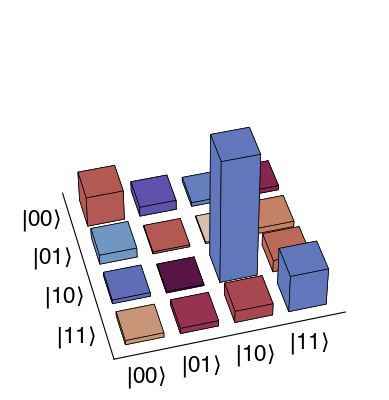

In [238]:
RESULT_FILENAME = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_14\result_0001_CNOT.pickle"
with open(RESULT_FILENAME, "rb") as result_file:
    measured_0001_CNOT = pickle.load(result_file)[0]

dm_savefig_wrapper(measured_0001_CNOT, "0001_CNOT_measured")

In [239]:
# RESULT_FILENAME = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_05_29\result_0010_CNOT"
# with open(RESULT_FILENAME, "rb") as result_file:
#     measured_0010 = pickle.load(result_file)[0]
#
# dm_savefig_wrapper(measured_0010, "0010_CNOT_measured")

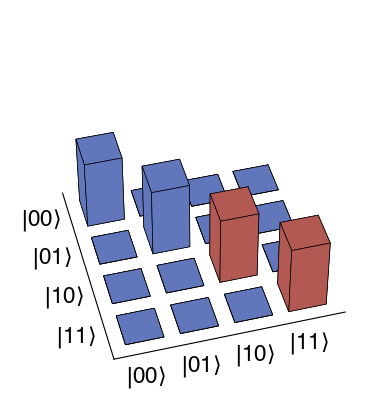

In [240]:
dm_savefig_wrapper(op.Iz, "Iz_tomography")

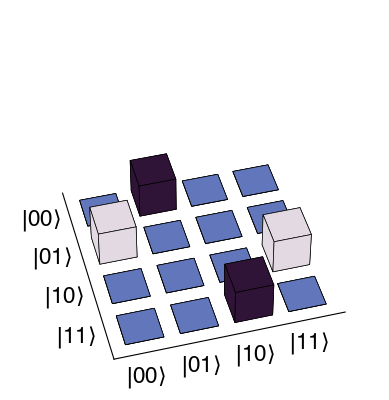

In [241]:
dm_savefig_wrapper(op.IzSy, "IzSy_tomography")

In [242]:
display(-op.Iz)
display(op.IzSx)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-0.5  0.   0.   0. ]
 [ 0.  -0.5  0.   0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.5]]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.    0.25  0.    0.  ]
 [ 0.25  0.    0.    0.  ]
 [ 0.    0.    0.   -0.25]
 [ 0.    0.   -0.25  0.  ]]

I think this operator (IzSy) from the X1X2 imaginary spectra looks better? Cuz of the black & white?
But maybe not worth the extra effort of switching everything from Y1Y2 real to X1X2 imag. 

In [243]:
# fig_IzSx, ax_IzSx = plot_complex_density_matrix(op.IzSy * 0.3, label_qubit=True, label_size=MATRIX_LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=False, show=False)
# ax_IzSx.tick_params(axis='x', direction='in', pad=10)
# ax_IzSx.tick_params(axis='z', direction='in', pad=0)
# plt.show()